In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Lecture 04

## Percentiles 

Suppose we wanted to manually compute the 55th percentile of the following array:

In [2]:
x = make_array(43, 20, 51, 7, 28, 34)

**Step 1.** To compute percentiles we first sort the data

In [3]:
sorted_x = np.sort(x)
sorted_x

array([ 7, 20, 28, 34, 43, 51])

In [5]:
ptbl = Table().with_columns(
    "Percentile", 100*(np.arange(0, len(x))+1)/len(x),
    "Element", sorted_x)
ptbl

Percentile,Element
16.6667,7
33.3333,20
50,28
66.6667,34
83.3333,43
100,51


**Step 2.** Figure out where the $p^\text{th}$ percentile would be.

In [16]:
p = 0
ind = int(np.ceil(p/100 *6) - 1)
ind

-1

In [17]:
sorted_x.item(ind)

51

The above calculation is confusing and brittle (try p=0).  Instead, we should use the `percentile` function.

### Using the Percentile Function

In [18]:
percentile?

Recall the precentile table. 

In [19]:
ptbl

Percentile,Element
16.6667,7
33.3333,20
50,28
66.6667,34
83.3333,43
100,51


Let's try a few values.

In [20]:
percentile(50, x)

28

In [22]:
percentile(55, x)

34

In [23]:
percentile(0, x)

7

In [24]:
percentile(100, x)

51

<br><br><br><br>

---
<center> Return to Slides </center>

---

<br><br><br><br>

## Discussion Question

In [25]:
s = make_array(1, 3, 5, 7, 9)

In [26]:
Table().with_columns(
    "Percentile", 100*(np.arange(0, len(s))+1)/len(s),
    "Element", sorted(s))

Percentile,Element
20,1
40,3
60,5
80,7
100,9


In [27]:
percentile(10, s) == 0

False

In [28]:
percentile(10, s)

1

In [29]:
percentile(39, s) == percentile(40, s)

True

In [30]:
percentile(40, s) == percentile(41, s)

False

In [31]:
percentile(50, s) == 5

True

<br><br><br><br>

---
<center> Return to Slides </center>

---

<br><br><br><br>

## Inference: Estimation

To demonstrate the process of estimating a parameter, let's examine the 2019 San Francisco public records.  We obtained this data from the [SF Open Data Portal](https://datasf.org/opendata/).  For the purposes of this exercise, we will assume that this a census of the compensation data: that it contains the compensation for a public workers.  

In [33]:
sf = Table.read_table('data/san_francisco_2019.csv')
sf.show(3)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332,0,40059,131391
Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241,0,49279,172520
Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715,0,46752,162468


Suppose we are interested in studying `"Total Compensation"`.  Let's make a histogram of the total compensation.

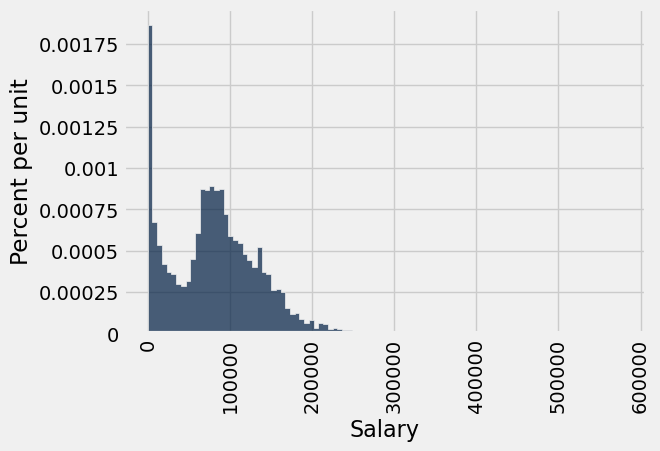

In [36]:
sf.hist("Salary", bins=100)

Who is getting paid the most?

In [37]:
# Who made the most money
sf.sort('Salary', descending=True).show(10)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
General Administration & Finance,Retirement Services,Administrative & Mgmt (Unrep),Chief Investment Officer,577633,0,146398,724031
General Administration & Finance,Retirement Services,Unassigned,Managing Director,483072,0,134879,617951
General Administration & Finance,Retirement Services,Unassigned,Managing Director,482649,0,134905,617554
General Administration & Finance,Retirement Services,Unassigned,Managing Director,451507,0,120276,571784
General Administration & Finance,Retirement Services,Unassigned,Managing Director,449378,0,120857,570235
Public Protection,Fire Department,Management,Dep Chf of Dept (Fire Dept),436585,0,36018,472603
Community Health,Public Health,Administrative & Mgmt (Unrep),"Physician Administrator, DPH",434966,0,119213,554179
Public Protection,Fire Department,Management,Assistant Deputy Chief 2,410501,0,52787,463288
Community Health,Public Health,Medical & Dental,Supervising Physician Spec,404701,0,99480,504181
Community Health,Public Health,Medical & Dental,Senior Physician Specialist,400992,0,97428,498421


Who is getting paid the least?

In [38]:
sf.sort('Salary', descending=False).show(10)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Juvenile Court,Correction & Detention,"Counselor, Log Cabin Rch PERS",-338,602,87,351
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer,0,0,0,0
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer,0,27,0,27
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer SFERS,0,128,2,130
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer SFERS,0,76,1,77
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer SFERS,0,178,3,181
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer SFERS,0,192,3,195
Public Protection,Trial Courts,Untitled,Court Staff Attorney II,0,0,1188,1188
Public Protection,District Attorney,Legal & Court,Sr District Atty Investigator,0,1036,18,1054
Public Protection,District Attorney,Legal & Court,Sr District Atty Investigator,0,768,13,781


There is a clear spike around **zero**!  Why?
<br><br><br><br>


We will focus on those that worked at least 20 hours at minimum wage for an entire year. 

In [39]:
min_salary = 15 * 20 * 50 # $15/hr, 20 hr/wk, 50 weeks
print("Min Salary", min_salary)

sf = sf.where('Salary', are.above(min_salary))

Min Salary 15000


/home/jovyan/.local/lib/python3.10/site-packages/datascience/tables.py:5865: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


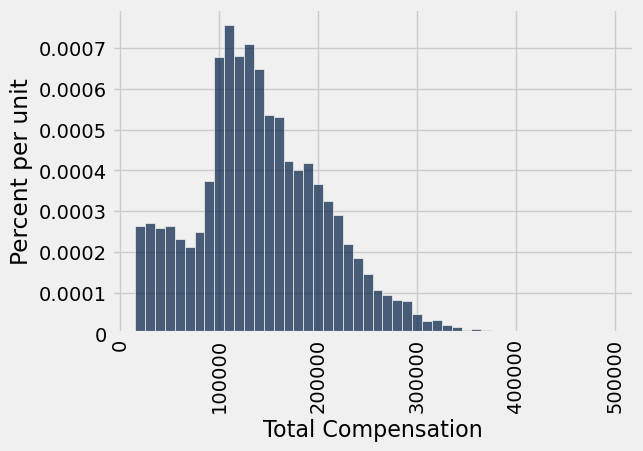

In [42]:
salary_bins = np.arange(min_salary, 500000, 10000)
sf.hist("Total Compensation", bins=salary_bins)

### The Population Parameter

Here we have access to the population so we can compute parameters directly.  

For example, suppose we were interested in the median compensation.  Then we could compute it directly on our data:

In [44]:
pop_median = percentile(50, sf.column("Salary"))
pop_median

89203.0

In most real-world settings, you won't have access to the population.  Instead, you will take a random sample. 

Suppose we sample 400 people from our population.

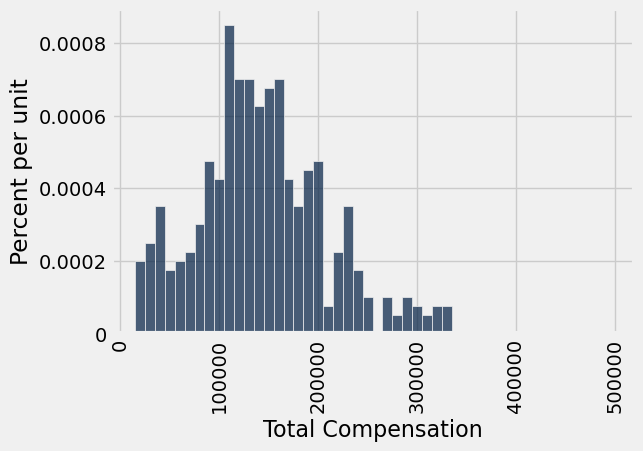

In [51]:
# An Empirical Distribution 
# sample 400 from population
our_sample = sf.sample(400, with_replacement=False) 
our_sample.hist('Salary', bins=salary_bins)

We can use the sample median (statistic) as an estimate of the parameter value.

In [53]:
# Estimate: Median of a Sample
percentile(50, our_sample.column('Salary'))

87974.0

But in the real world we won't be able to keep going back to the population. How do we generate a new random sample *without going back to the population?*

<br><br><br><br>

---
<center> Return to Slides </center>

---

<br><br><br><br>

## Variability of the Estimate

If we could get additional samples from the population, how much variability would their be in our estimate of the median?

In [54]:
def generate_sample_median(samp_size):
    new_sample = sf.sample(samp_size, with_replacement=False)
    return percentile(50, new_sample.column('Salary'))

In [62]:
generate_sample_median(400)

90963.0

<br><br><br><br>

## Quantifying Uncertainty

Because we have access to the population, we can simulate many samples from the population:

In [66]:
sample_medians = make_array()

for i in np.arange(1000):
    new_median = generate_sample_median(400)
    sample_medians = np.append(sample_medians, new_median)

/home/jovyan/.local/lib/python3.10/site-packages/datascience/tables.py:5865: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


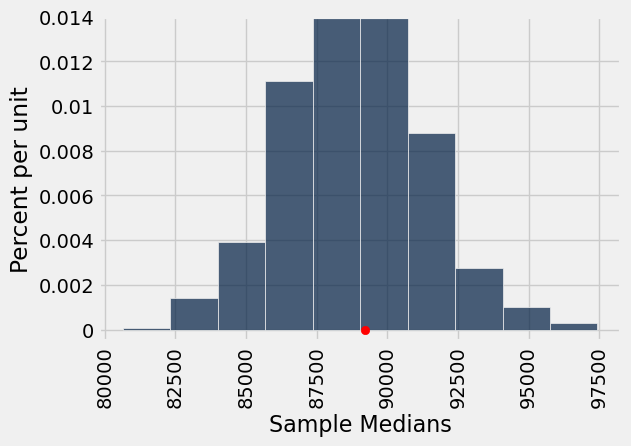

In [69]:
Table().with_column('Sample Medians', sample_medians).hist()

plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color='red');

What happens if we do the same thing again with slightly larger samples?

In [ ]:
sample_medians2 = make_array()

for i in np.arange(1000):
    new_median = generate_sample_median(800)
    sample_medians2 = np.append(sample_medians2, new_median)

In [ ]:
(Table()
     .with_columns("Sample Medians", sample_medians,
                   "Sample Size", 400)
     .append(Table().with_columns("Sample Medians", sample_medians2,
                                  "Sample Size", 800))
     .hist("Sample Medians", group="Sample Size", bins=med_bins)
)
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color='red');

But in the real world we won't be able to keep going back to the population. How do we generate a new random sample *without going back to the population?*

<br><br><br><br>

---
<center> Return to Slides </center>

---

<br><br><br><br>

# Bootstrap

Sample randomly
 - from the original sample
 - with replacement
 - the same number of times as the original sample size
 
 <br> <br> <br>

**Step 1:** Sample the original sample **With Replacement** the same number of times as the original sample size.

```python
table.sample() # All you need!
```

The default behavior of tbl.sample:
1. at random with replacement,
2. the same number of times as rows of tbl

In [71]:
#our_sample

In [81]:
bootstrap_sample = our_sample.sample()
print("Number of Rows:", bootstrap_sample.num_rows)

Number of Rows: 400


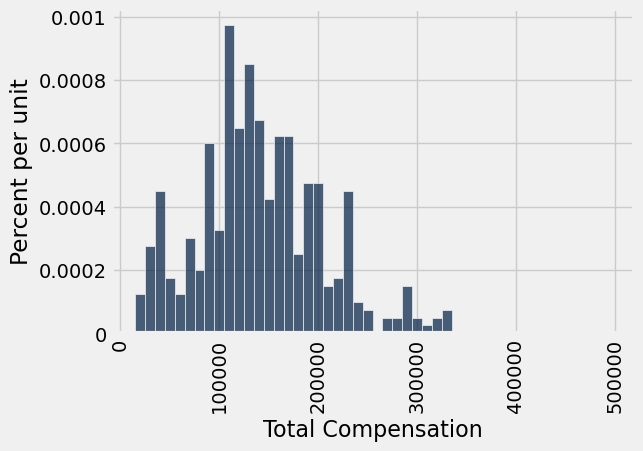

In [82]:
bootstrap_sample.hist('Total Compensation', bins=salary_bins)

**Step 2:** Compute statistic on bootstrap sample.

In [83]:
percentile(50, bootstrap_sample.column('Salary'))

85236.0

**Repeat** the sampling process many times:

In [86]:
def one_bootstrap_median():
    # draw the bootstrap sample
    bootstrap_sample = our_sample.sample()
    # return the median total compensation in the bootstrap sample
    return percentile(50, bootstrap_sample.column('Salary'))

In [90]:
one_bootstrap_median()

86000.0

In [91]:
# Generate the medians of 1000 bootstrap samples
num_repetitions = 1000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())

Examine the empirical distribution of the samples.

/home/jovyan/.local/lib/python3.10/site-packages/datascience/tables.py:5865: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


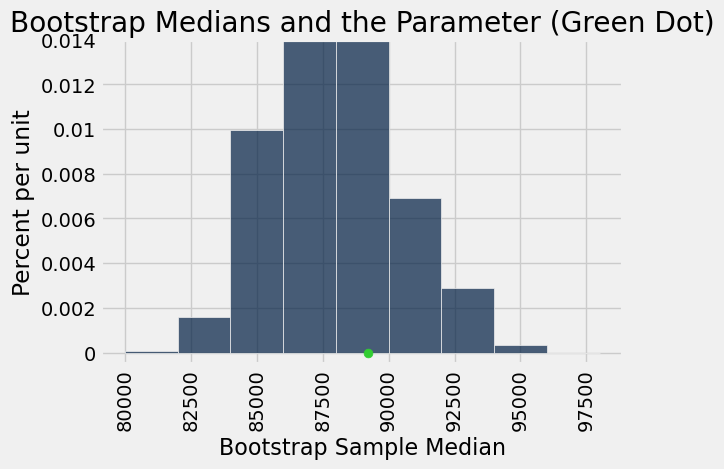

In [96]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
median_bins=np.arange(80000, 100000, 2000)
resampled_medians.hist(bins=median_bins)

# Plotting parameters; you can ignore this code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.title('Bootstrap Medians and the Parameter (Green Dot)');

### A General Bootstrap Function

The following function implements the general bootstrap procedure.


In [98]:
def bootstrapper(sample, statistic, num_repetitions):
    """
    Returns the statistic computed on a num_repetitions  
    bootstrap samples from sample.
    """
    bstrap_stats = make_array()
    for i in np.arange(num_repetitions):
        # Step 1: Sample the Sample
        bootstrap_sample = sample.sample()
        # Step 2: compute statistics on the sample of the sample
        bootstrap_stat = statistic(bootstrap_sample)
        # Accumulate the statistics
        bstrap_stats = np.append(bstrap_stats, bootstrap_stat)

    return bstrap_stats    

In [108]:
og_sample = sf.sample(400)

def compute_median(sample):
    return percentile(50, sample.column("Salary"))

bootstrap_medians = bootstrapper(og_sample, compute_median, 1000)

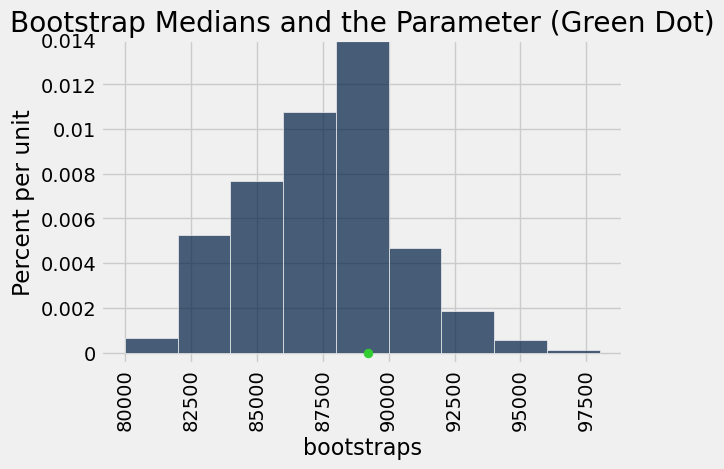

In [109]:
(Table().with_column("bootstraps", bootstrap_medians)
        .hist(bins=median_bins))

## Extra Viz code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.title('Bootstrap Medians and the Parameter (Green Dot)');

<br><br><br><br>

---
<center> Return to Slides </center>

---

<br><br><br><br>

## Percentile Method: Middle 95% of the Bootstrap Estimates 

Computing confidence intervals is as simple as computing percentiles on the bootstrap samples.  No magic equations!

In [111]:
left = percentile(2.5, bstrap_medians) #  2.5 percentile
right = percentile(97.5, bstrap_medians) #  97.5 percentile 

make_array(left, right)

array([ 83820.,  93301.])

In [ ]:
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
plots.ylim(-0.000005, 0.00014)
plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=3, zorder=1)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2);